In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import matplotlib.pyplot as plt
import os
from binance.client import Client
from keys import keys
from functions import get_candles
import seaborn as sns
# from datetime import timedelta, datetime
# from dateutil import parser
# from bitmex import bitmex
# from keys import keys
# from tqdm import tqdm

binance_client = Client(api_key=keys['binance']['apiKey'], api_secret=keys['binance']['secret'])

In [3]:
info = binance_client.futures_exchange_info()

In [4]:
tickers = binance_client.futures_ticker()

In [5]:
vol = pd.DataFrame([(t['symbol'], float(t['volume']), float(t['weightedAvgPrice'])) for t in tickers],
                   columns=['symbol', 'volume', 'price'])
vol['nominal_volume'] = vol.volume * vol.price
vol = vol.sort_values('nominal_volume', ascending=False)
print(vol.head(10))
symbols = vol.symbol.values

       symbol           volume       price   nominal_volume
0     BTCUSDT     157697.77200 19116.51000 3014631035.41572
1     ETHUSDT    1832597.68900   595.39000 1091110338.05371
3     XRPUSDT 1257238171.90000     0.60330  758491789.10727
8    LINKUSDT   11868752.97000    13.15200  156097839.06144
47  SUSHIUSDT   65311735.00000     2.18880  142954325.56800
5     LTCUSDT    1664221.37800    82.92000  137997236.66376
41    YFIUSDT       4582.60200 28780.40000  131889118.60080
36  WAVESUSDT    8673634.20000     8.20850   71197526.33070
9     XLMUSDT  408400149.00000     0.17353   70869677.85597
2     BCHUSDT     244880.87200   285.86000   70001646.06992


In [6]:
future_files = [x for x in os.listdir('data/candles') if 'futures' in x]

In [38]:
freq='1min'
min_length = 4000 * 60 # In minutes
files = os.listdir('data/candles')

df = pd.DataFrame()
for symbol in symbols:
    file = 'data/candles/' + symbol + '-1m-futures-data.csv.zip'
    if symbol + '-1m-futures-data.csv.zip' in files:
        data = pd.read_csv(file)
        if len(data) < min_length:
            continue
        data['timestamp'] = pd.to_datetime(data.timestamp, format='%Y-%m-%d %H:%M:%S')
        data.set_index('timestamp', inplace=True)
        data = get_candles(data, freq)   
        df[symbol] = data.close
    
symbols = df.columns

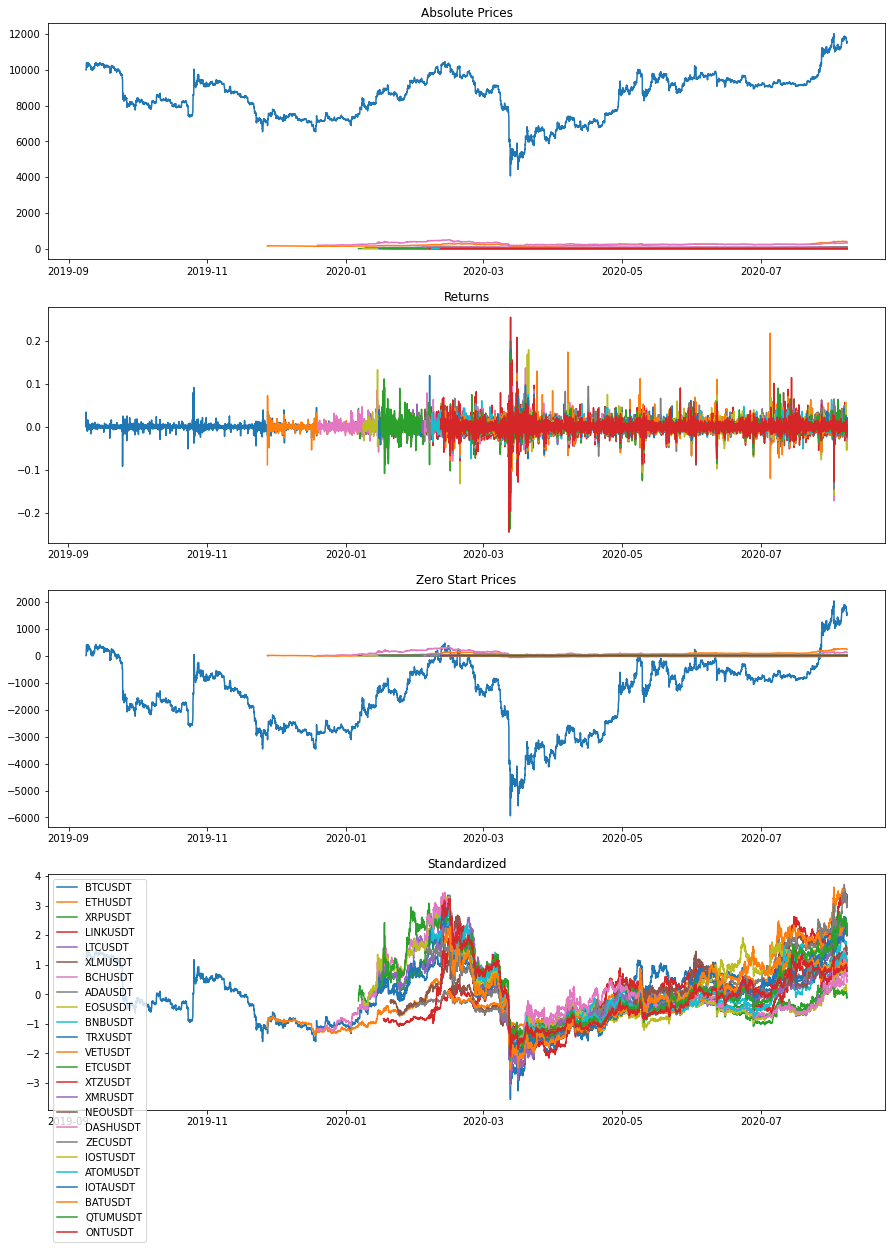

In [8]:
fig, (ax0,ax1,ax2, ax3) = plt.subplots(4,1, figsize=(15,20))
for symbol in symbols:
    ax0.plot(df[symbol], label=symbol)
    ax1.plot(df[symbol].pct_change(), label=symbol)
    ax2.plot(df[symbol].dropna() - df[symbol].dropna().values[0], label=symbol)
    ax3.plot((df[symbol]- df[symbol].mean())/df[symbol].std(), label=symbol)
ax0.set_title('Absolute Prices')
ax1.set_title('Returns')
ax2.set_title('Zero Start Prices')
ax3.set_title('Standardized')
ax3.legend()

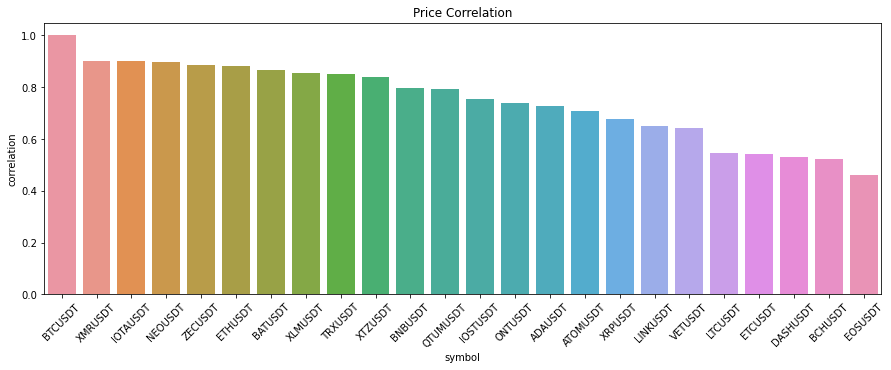

In [9]:
price_corr = df.corr()['BTCUSDT'].reset_index().sort_values('BTCUSDT', ascending=False)
price_corr.columns = ['symbol', 'correlation']
plt.figure(figsize=(15,5))
chart = sns.barplot(data=price_corr, x='symbol', y='correlation')
labels = chart.get_xticklabels()
chart.set_xticklabels(labels, rotation=45);
plt.title('Price Correlation');

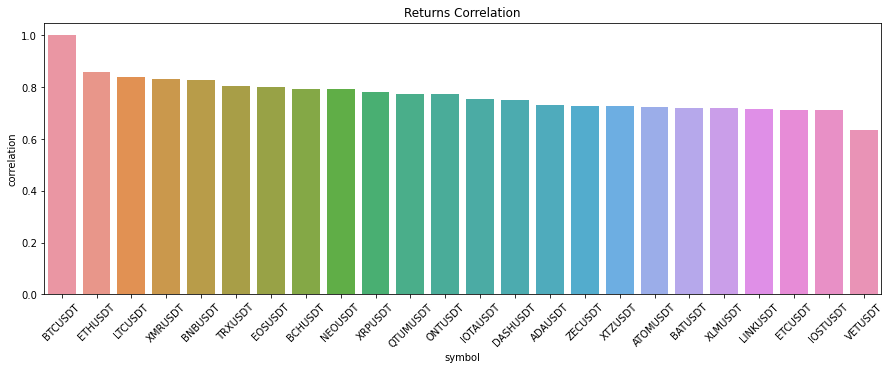

In [10]:
price_corr = df.pct_change().corr()['BTCUSDT'].reset_index().sort_values('BTCUSDT', ascending=False)
price_corr.columns = ['symbol', 'correlation']
plt.figure(figsize=(15,5))
chart = sns.barplot(data=price_corr, x='symbol', y='correlation')
labels = chart.get_xticklabels()
chart.set_xticklabels(labels, rotation=45);
plt.title('Returns Correlation');

In [63]:
file = 'data/candles/' + 'BTCUSDT' + '-1m-futures-data.csv.zip'
df = pd.read_csv(file)
df['timestamp'] = pd.to_datetime(df.timestamp, format='%Y-%m-%d %H:%M:%S')
df.set_index('timestamp', inplace=True)
df = df[df.index>='2020-01-01 0:00:00']
df['dif'] = df.close.diff()

In [68]:
df.dif.sort_values().head()

timestamp
2020-05-10 00:20:00   -578.19000
2020-08-02 04:40:00   -456.40000
2020-08-02 04:38:00   -441.66000
2020-06-02 14:46:00   -361.86000
2020-03-13 02:40:00   -357.40000
Name: dif, dtype: float64

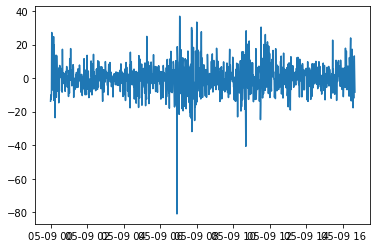

In [81]:
plt.plot(df[df.index>='2020-05-9 00:00:00'].dif[0:1000])

## Mean reversion between different cryptocurrencies

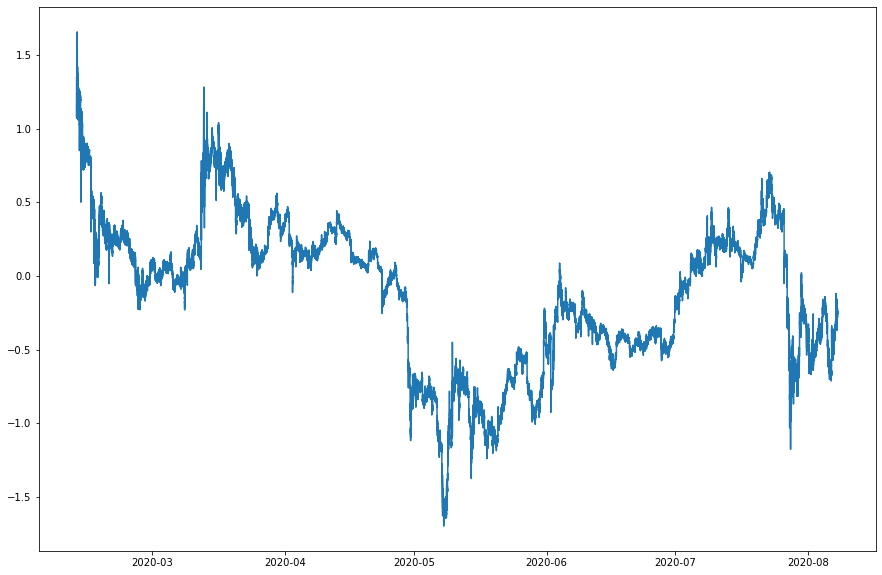

In [50]:
a='IOTAUSDT'
a=(df[a]- df[a].mean())/df[a].std()
b='BTCUSDT'
b=(df[b]- df[b].mean())/df[b].std()

plt.figure(figsize=(15,10))
plt.plot(a-b)
# plt.plot(a)
# plt.plot(b)

In [41]:
df.ETHUSDT.index.max()

Timestamp('2020-08-07 21:09:00', freq='T')

In [35]:
df.ETHUSDT.index.min()

Timestamp('2019-09-08 17:00:00', freq='H')

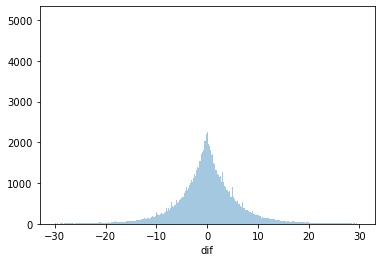

In [87]:
sns.distplot(df[(30>df.dif)&(df.dif>-30)].dif, kde=False, bins=1000)

In [151]:
price_corr = df.pct_change().std().reset_index().sort_values('BTCUSDT', ascending=False)
price_corr.columns = ['symbol', 'correlation']
plt.figure(figsize=(15,5))
chart = sns.barplot(data=price_corr, x='symbol', y='correlation')
labels = chart.get_xticklabels()
chart.set_xticklabels(labels, rotation=45);
plt.title('Returns Volatility');

AttributeError: 'numpy.float64' object has no attribute 'reset_index'